In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
y = 0. It's a non-cat picture.


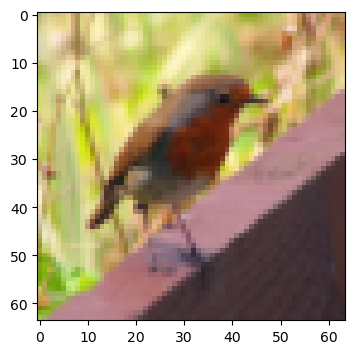

In [6]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
# пример картинки
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [7]:
# исследуем датасет 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [8]:
# Измените размерность обучающих и тестовых элементов
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Стандартизируйте данные, чтобы значения признаков находились в диапазоне от 0 до 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x: " + str(train_x.shape))
print ("test_x: " + str(test_x.shape))


train_x: (12288, 209)
test_x: (12288, 50)


In [9]:
### константы, определяющие модель####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [10]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Аргументы:
    n_x -- размер входного слоя
    n_h -- размер скрытого слоя
    n_y -- размер выходного слоя
    
    Возвращает:
    параметры -- словарь, содержащий параметры:
                    W1 -- матриза весов размерностью (n_h, n_x)
                    b1 -- вектор смещения размерностью (n_h, 1)
                    W2 -- матрица весов размерностью (n_y, n_h)
                    b2 -- вектор смещения размерностью (n_y, 1)
    """
    
    np.random.seed(1)
    
    ### начало кода ### (≈ 4 строки)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### конец кода ###
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [11]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Реализует прямое распространение для слоя LINEAR->ACTIVATION.

    Аргументы:
    A_prev -- активации из предыдущего слоя (или входные данные): (размер предыдущего слоя, кол-во элементов)
    W -- матрица весов: массив размерностью (размер текущего слоя, размер предыдущего слоя)
    b -- свободный член, массив размерностью (размер текущего слоя, 1)
    activation -- функция активации, которая будет использоваться на этом слое, хранится в виде текстовой строки: "sigmoid" or "relu"

    Возвращает:
    A -- вывод функции активации, также называемый активацией 
    cache -- словарь, содержащий "linear_cache" и "activation_cache";
             хранимый для эффективного расчета обратного распространения
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### Начало кода ### (≈ 2 строки)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### Конец кода ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### Начало кода ### (≈ 2 строки)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### Конец кода ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
def compute_cost(AL, Y):
    """
    Реализуйте функцию стоимости, определенную уравнением (7).

    Аргументы:
    AL -- вектор вероятности, соответствующий предсказаниям label, размерностью (1, количество элементов)
    Y -- вектор правильных "label" (например: 0 если не кошка, 1 если кошка), размерностью (1, количество элементов)

    Возвращает:
    cost -- значение функции стоимости в случае использования cross-entropy loss
    """
    
    m = Y.shape[1]

    # Вычислите потери aL и y.
    ### Начало кода ### (≈ 1 строка)
    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    ### Конец кода ###
    
    cost = np.squeeze(cost)      # Чтобы убедиться, что размернность вашей стоимости соответствует ожиданиям (например, [[17]] превращается в 17).
    assert(cost.shape == ())
    
    return cost

In [13]:
def linear_activation_backward(dA, cache, activation):
    """
    Реализует обратное распространение ошибки для слоя *LINEAR->ACTIVATION*.
    
    Аргументы:
    dA --постактивационный градиент для текущего слоя l 
    cache -- кортеж значений (linear_cache, active_cache), который мы храним для эффективного вычисления обратного распространения
    activation -- активация, которая будет использоваться на этом слое, хранится в виде текстовой строки: "sigmoid" или "relu".
    
    Возвращает:
    dA_prev -- Градиент стоимости относительно активации (предыдущего слоя l-1), той же размерности, что и A_prev.
    dW -- Градиент стоимости по отношению к W (текущий слой l), той же размерности, что и W
    db -- Градиент стоимости по отношению к b (текущий слой l), той же размерности, что и b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### Начало кода ### (≈ 2 строки)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### Конец кода ###
        
    elif activation == "sigmoid":
        ### Начало кода ### (≈ 2 строки)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### Конец кода ###
    
    return dA_prev, dW, db

In [14]:
def update_parameters(parameters, grads, learning_rate):
    """
    Обновите параметры, используя градиентный спуск
    
    Аргументы:
    parameters -- словерь, содержащий ваши параметры 
    grads -- словарь, сожержащий ваши градиенты, вывод L_model_backward
    
    Возвращает:
    parameters -- словарь, содержащий ваши обновленные параметры 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # число слоев в сети

    # Update rule для каждого параметра. Используйте цикл for.
    ### Начало кода ### (≈ 3 строки)
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    ### Конец кода ###
        
    return parameters

In [15]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Аргументы:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Возвращает:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### Начало кода ### (≈ 1 строка)
    Z = np.dot(W, A) + b
    ### Конец кода ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [16]:
def linear_backward(dZ, cache):
    """
    Реализуйте линейную часть обратного распространения для одного слоя (уровень l)
    
    Аргументы:
    dZ -- Градиент стоимости по отношению к линейному выходу (для слоя l)
    cache -- кортеж значений (A_prev, W, b), поступающих в результате прямого распространения в текущем слое

    Возвращает:
    dA_prev -- Градиент стоимости относительно активации (предыдущего слоя l-1), той же размерности, что и A_prev.
    dW -- Градиент стоимости по отношению к W (текущий слой l), той же размерности, что и W
    db -- Градиент стоимости по отношению к b (текущий слой l), той же размерности, что и b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### Начало кода ### (≈ 3 строки)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    ### Конец кода ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [17]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Реализует двухслойную нейронную сеть: LINEAR->RELU->LINEAR->SIGMOID.

     Args:
     X — входные данные размерностью (n_x, количество примеров)
     Y — вектор истинных «меток» (содержащий 1, если кошка, 0, если не кошка), формы (1, количество примеров)
     Layers_dims — размеры слоев (n_x, n_h, n_y)
     num_iterations — количество итераций цикла оптимизации
     Learning_rate — скорость обучения правила обновления градиентного спуска.
     print_cost — если установлено значение True, стоимость будет выводиться каждые 100 итераций.

     Return:
     параметры — словарь, содержащий W1, W2, b1 и b2.
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              #  чтобы отслеживать cost на всех этапах
    m = X.shape[1]                           # количество элементов
    (n_x, n_h, n_y) = layers_dims
    
    # Инициализируем словарь параметров, вызвав одну из ранее реализованных функций.
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Получите W1, b1, W2 и b2 из словаря parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Цикл (градиентный спуск)

    for i in range(0, num_iterations):

        # Прямое распространение: LINEAR -> RELU -> LINEAR -> SIGMOID. Ввод: "X, W1, b1". Вывод: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        
        # Рассчитаем cost
        cost = compute_cost(A2, Y)
        
        # Инициализируем обратное распространение
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Обратное распространение. Ввод: "dA2, cache2, cache1". Вывод: "dA1, dW2, db2; при этом dA0 (не используется), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        # Установим grads['dWl'] равным dW1, grads['db1'] равным db1, grads['dW2'] равным dW2, grads['db2'] равным db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Обновим параметры.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Получаем W1, b1, W2, b2 из параметров
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Выводим cost каждые 100 тренировочных экземпляров
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # Построим график
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764731
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257517
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.35807050113237937
Cost after iteration 1000: 0.3394281538366411
Cost after iteration 1100: 0.3052753636196268
Cost after iteration 1200: 0.27491377282130275
Cost after iteration 1300: 0.24681768210614793
Cost after iteration 1400: 0.19850735037466122
Cost after iteration 1500: 0.17448318112556363
Cost after iteration 1600: 0.1708076297809549
Cost after iteration 1700: 0.11306524562164766
Cost after iteration 1800: 0.09629426845937145
Cost after iteration 1900: 0.08342617959726881
Cost after iteration 2000: 0.0743907870431909
Cost after iteration 2100: 0.0663074813

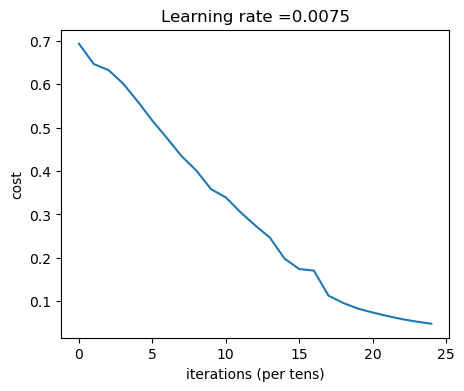

In [18]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [19]:
def L_model_forward(X, parameters):
    """
   Реализуйте прямое распространение для вычисления [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Аргументы:
    X -- данные, массив размерностью (размер инпута, количество элементов)
    parameters -- вывод initialize_parameters_deep()
    
    Возвращает:
    AL -- последнее значение после активации
    caches -- список caches,  содержащий:
                каждый кеш Linear_relu_forward() (их L-1, проиндексированных от 0 до L-2)
                 кеш Linear_sigmoid_forward() (один, с индексом L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # количество слоев
    
    # реализация [LINEAR -> RELU]*(L-1). Добавьте "cache" в список "caches".
    for l in range(1, L):
        A_prev = A 
        ### Начало кода ### (≈ 2 строки)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu')
        caches.append(cache)
        ### Конец кода ###
    
    # Реализация LINEAR -> SIGMOID. Добавьте "cache" в список "caches".
    ### Начало кода ### (≈ 2 строки)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    ### Конец кода ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [20]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [21]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [22]:
### Константы ###
layers_dims = [12288, 20, 7, 5, 1] #  5-слойная модель

In [23]:
def initialize_parameters_deep(layer_dims):
    """
    Аргументы:
    layer_dims -- массив (список), содержащий размерности для каждого слоя в нашей сети
    
    Возвращает:
    parameters -- словарь, содержащий параметры "W1", "b1", ..., "WL", "bL":
                    Wl -- матрица весов размерностью (layer_dims[l], layer_dims[l-1])
                    bl -- вектор смещения размерностью (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # кол-во слоев в сети

    for l in range(1, L):
        ### Начало кода ### (≈ 2 строчки)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### Конец кода ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [24]:
def L_model_backward(AL, Y, caches):
    """
    Реализует обратное распространение для всей сети [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID.
    
    Аргументы:
    AL -- вектор вероятностей, вывод прямого распространения (L_model_forward())
    Y -- вектор действительных "label" (содержит 0 если не-кошка, 1 если кошка)
    caches -- список caches, содержащий:
                каждый кеш линейной_активации_forward() с «relu» (это кэши[l], для l в диапазоне (L-1), т.е. l = 0...L-2)
                кеш линейной_активации_forward() с «sigmoid» (это кеши[L-1])
    Возвращает:
    grads -- словарь с градиентами
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)  # количество слоев
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # после этой строки Y такой же размерности, как и AL
    
    # Инициализация обратного распространения
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # L-й градиент (SIGMOID -> LINEAR)
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        # l-й слой: (RELU -> LINEAR) градиенты.
        # Входные данные: "grads["dA" + str(l + 1)], кэши". Выходы: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


In [25]:
def update_parameters(parameters, grads, learning_rate):
    """
    Обновите параметры, используя градиентный спуск
    
    Аргументы:
    parameters -- словерь, содержащий ваши параметры 
    grads -- словарь, сожержащий ваши градиенты, вывод L_model_backward
    
    Возвращает:
    parameters -- словарь, содержащий ваши обновленные параметры 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # число слоев в сети

    # Update rule для каждого параметра. Используйте цикл for.
    ### Начало кода ### (≈ 3 строки)
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    ### Конец кода ###
        
    return parameters

In [26]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Реализует нейронную сеть c L слоями: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
     Args:
     X -- данные, массив размерностью (количество примеров, num_px * num_px * 3)
     Y — вектор истинных «меток» (содержащий 0, если кошка, 1, если не кошка), размерностью (1, количество примеров)
     Layers_dims — список, содержащий входной размер и размер каждого слоя длиной (количество слоев + 1).
     Learning_rate — скорость обучения правила обновления градиентного спуска.
     num_iterations — количество итераций цикла оптимизации
     print_cost — если True, cost печатается каждые 100 шагов.
    
     Returns:
     parameters — параметры, изученные моделью. Затем их можно использовать для прогнозирования.
    """

    np.random.seed(1)
    costs = []                         # Отслеживаем значение cost
    
    # Инициализация параметров
    ### Начало кода ###
    parameters = initialize_parameters_deep(layers_dims)
    ### Конец кода ###
    
    # Цикл (градиентный спуск)
    for i in range(0, num_iterations):

        # Прямое распространение: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### Начало кода ### (≈ 1 строчка кода)
        AL, caches = L_model_forward(X, parameters)
        ### Конец кода ###
        
        # Высчитываем cost.
        ### Начало кода ### (≈ 1 строчка кода)
        cost = compute_cost(AL, Y)
        ### Конец кода ###
    
        # Обратное распространение.
        ### Начало кода ### (≈ 1 строчка кода)
        grads = L_model_backward(AL, Y, caches)
        ### Конец кода ###
 
        # Обновление параметров.
        ### Начало кода ### (≈ 1 строчка кода)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### Конец кода ###
                
        # Выводим cost каждые 100 тренировочных экземпляров
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # строим график
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693148
Cost after iteration 100: 0.682443
Cost after iteration 200: 0.674105
Cost after iteration 300: 0.667605
Cost after iteration 400: 0.662532
Cost after iteration 500: 0.658566
Cost after iteration 600: 0.655463
Cost after iteration 700: 0.653030
Cost after iteration 800: 0.651121
Cost after iteration 900: 0.649619
Cost after iteration 1000: 0.648438
Cost after iteration 1100: 0.647507
Cost after iteration 1200: 0.646772
Cost after iteration 1300: 0.646192
Cost after iteration 1400: 0.645733
Cost after iteration 1500: 0.645370
Cost after iteration 1600: 0.645082
Cost after iteration 1700: 0.644854
Cost after iteration 1800: 0.644674
Cost after iteration 1900: 0.644530
Cost after iteration 2000: 0.644416
Cost after iteration 2100: 0.644326
Cost after iteration 2200: 0.644254
Cost after iteration 2300: 0.644197
Cost after iteration 2400: 0.644151


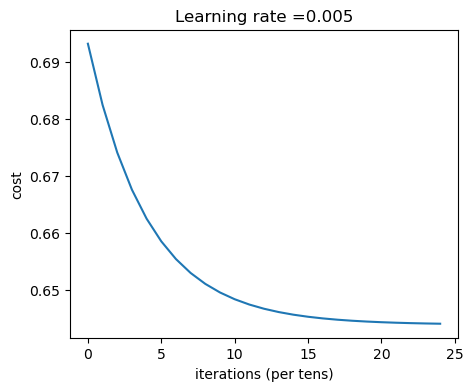

In [27]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 2500, print_cost = True)

In [29]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [30]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


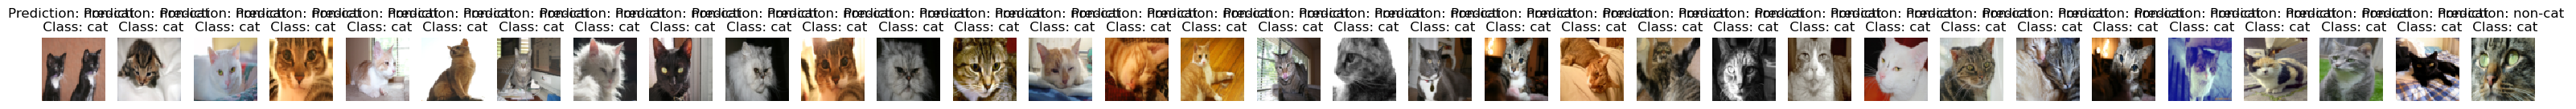

In [31]:
print_mislabeled_images(classes, test_x, test_y, pred_test)